In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import glob
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive

/content/drive


In [ ]:
cd My Drive

/content/drive/My Drive


In [ ]:
"""cd data"""

'cd data'

In [ ]:
"""cd train"""

'cd train'

In [ ]:
cd data

/content/drive/My Drive/data


In [ ]:
x_normal = np.load('x_normal.npy')
y_normal = np.load('y_normal.npy')
x_viral = np.load('x_viral.npy')
y_viral = np.load('y_viral.npy')
x_bacterial = np.load('x_bacterial.npy')
y_bacterial = np.load('y_bacterial.npy')

In [ ]:
print(x_viral.shape)
print(y_viral.shape)
print(x_bacterial.shape)
print(y_bacterial.shape)

(1504, 256, 256, 3)
(1504,)
(2786, 256, 256, 3)
(2786,)


In [ ]:
x_covid = np.load('x_covid.npy')
y_covid = np.load('y_covid.npy')

In [ ]:
print(x_covid.shape)
print(y_covid.shape)

(239, 256, 256, 3)
(239,)


In [ ]:
import random

In [ ]:
x_train=[]
y_train=[]
x_test = []
y_test = []



---

**Load viral images**

---



In [ ]:
nums = random.sample(range(0, 1504), 200)
for i in nums:
  
  x_train.append(x_viral[i])
  y_train.append(0)

In [ ]:
total = [i for i in range(0,1504)]
test_nums = random.sample(list((set)(total)-(set)(nums)),45)

In [ ]:
for i in test_nums:
  x_test.append(x_viral[i])
  y_test.append(0)



---

**Load covid images**

---



In [ ]:
nums = random.sample(range(0, 239), 200)
for i in nums:
  x_train.append(x_covid[i])
  y_train.append(1)

In [ ]:
total = [i for i in range(0,239)]
test_nums = random.sample(list((set)(total)-(set)(nums)),39)

In [ ]:
for i in test_nums:
  x_test.append(x_covid[i])
  y_test.append(1)



---

**add  5 cov TMC images to train set**

---



In [ ]:
x_covid_tmc=[]
y_covid_tmc=[]

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid TMC/*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  x_covid_tmc.append(img)
  y_covid_tmc.append(1)

In [ ]:
print(len(x_covid_tmc))
print(len(y_covid_tmc))

11
11


In [ ]:
nums = random.sample(range(0, 11), 5)
for i in nums:
  x_train.append(x_covid_tmc[i])
  y_train.append(1)

In [ ]:
x_sample = []
y_sample = []

In [ ]:
total = [i for i in range(0,11)]
test_nums = random.sample(list((set)(total)-(set)(nums)),6)
for i in test_nums:
  x_test.append(x_covid_tmc[i])
  y_test.append(1)

In [ ]:
x_train = np.asarray(x_train)
y_train= np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(405, 256, 256, 3)
(405,)
(90, 256, 256, 3)
(90,)


Model for 1 Densenet block

In [ ]:
%tensorflow_version 1.x
import tensorflow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

#model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
#model.add(layers.BatchNormalization())
#model.add(layers.LeakyReLU(alpha=0.1))

#model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

#model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
#model.add(layers.BatchNormalization())
#model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
 
model.add(layers.Flatten())
 
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
opt = adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=32)
mc = ModelCheckpoint('nor_inf_04jun03.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=model.fit(x_train,y_train,batch_size=16,validation_split=0.2,epochs=100,callbacks=[es,mc],shuffle=True)

Train on 324 samples, validate on 81 samples
Epoch 1/100
324/324 [==============================] - 31s 94ms/step - loss: 0.3768 - accuracy: 0.8395 - val_loss: 0.5212 - val_accuracy: 0.8765

Epoch 00001: val_accuracy improved from -inf to 0.87654, saving model to nor_inf_04jun03.h5
Epoch 2/100
324/324 [==============================] - 29s 88ms/step - loss: 0.1697 - accuracy: 0.9506 - val_loss: 0.6624 - val_accuracy: 0.5926

Epoch 00002: val_accuracy did not improve from 0.87654
Epoch 3/100
324/324 [==============================] - 30s 94ms/step - loss: 0.1137 - accuracy: 0.9599 - val_loss: 0.6978 - val_accuracy: 0.5185

Epoch 00003: val_accuracy did not improve from 0.87654
Epoch 4/100
324/324 [==============================] - 28s 88ms/step - loss: 0.0941 - accuracy: 0.9753 - val_loss: 0.6477 - val_accuracy: 0.5679

Epoch 00004: val_accuracy did not improve from 0.87654
Epoch 5/100
324/324 [==============================] - 28s 87ms/step - loss: 0.0806 - accuracy: 0.9753 - val_loss:

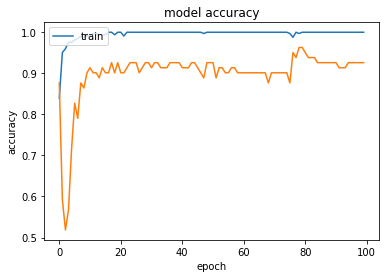

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show() 

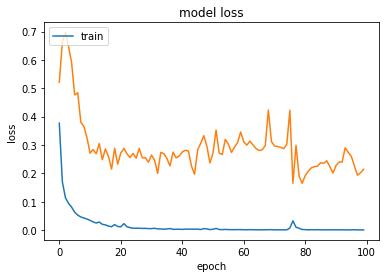

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("LDN3_w-o.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("LDN3_w-o.h5")
model.save("LDN3_w-o.h5")
json_file.close()

In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('LDN3_w-o.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("LDN3_w-o.h5")

In [ ]:

v=np.zeros(shape=(1500,1))
c=np.ones(shape=(300,1))


x_test=np.concatenate((x_viral[1480:1500],x_covid[219:239]))
y_test=np.concatenate((v[0:20],c[0:20]))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print("test accuracy: ",test_acc,)
print("test loss    : ",_)

test accuracy:  0.5
test loss    :  6.915242934184789


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred.shape

(40, 1)

In [ ]:
y_pred[0]
classes = np.argmax(y_pred,axis=-1)

In [ ]:
(type)(classes)
classes.shape

(40,)

In [ ]:
label = []
for i in y_pred:
  if i>0.5:
    label.append(1)
  else :
    label.append(0)
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

40


In [ ]:
y_test=np.asarray(y_test)

In [ ]:
from sklearn.metrics import accuracy_score
test_acc=accuracy_score(y_test, label)

In [ ]:
test_acc

0.5

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,label))

[[ 0 20]
 [ 0 20]]


-----------------------------------
TP :  0
TN :  20
FP :  0
FN :  20
sensitivity :  0.0
specificity :  1.0


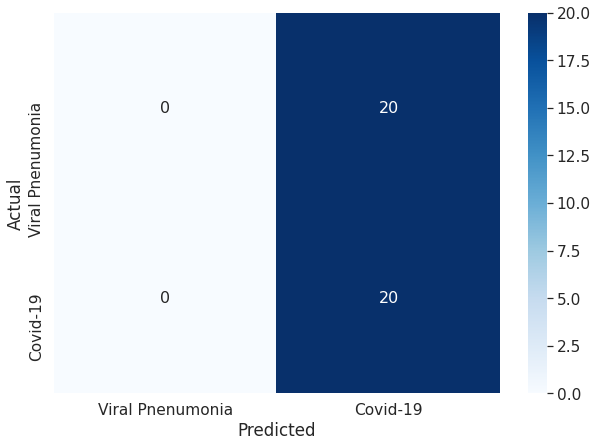

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,label)

import seaborn as sns
df_cm = pd.DataFrame(cm, columns=['Viral Pnenumonia','Covid-19'], index =['Viral Pnenumonia','Covid-19'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='d')




fp=cm[1][0]
fn=cm[0][1]
tp=cm[0][0]
tn=cm[1][1]
print("-----------------------------------")
print("TP : ",tp)
print("TN : ",tn)
print("FP : ",fp)
print("FN : ",fn)
print("sensitivity : ",tp/(float)((tp+fn)))
print("specificity : ",tn/(float)((tn+fp)))
sn=tp/(float)((tp+fn))
sp=tn/(float)((tn+fp))


TMC XRAY images

In [ ]:
print(len(x_samples))
print(len(y_samples))

8
8


In [ ]:
for i in range(8):
    img = x_samples[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    x_samples[i]=img

In [ ]:
print('Shape of sample images: ', x_samples[0].shape)

Shape of sample images:  (256, 256, 3)


In [ ]:
x_samples=np.array(x_samples)
print(x_samples.shape)

(8, 256, 256, 3)


In [ ]:
y_samples_pred=model.predict(x_samples)

In [ ]:
sample_labels = []
for i in y_samples_pred:
  if i>0.5:
    sample_labels.append('infected')
  else :
    sample_labels.append('normal') 
print(len(sample_labels))
sample_labels = np.asarray(sample_labels)
sample_labels=sample_labels.reshape(-1,1)

8


In [ ]:
print(y_samples_pred)

[[1.       ]
 [1.       ]
 [0.9999982]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]]


In [ ]:
print(sample_labels.shape)

(8, 1)


In [ ]:
print(sample_labels)

[['infected']
 ['infected']
 ['infected']
 ['infected']
 ['infected']
 ['infected']
 ['infected']
 ['infected']]
